# Notebook to generate a unit summary plot.

This notebook will generate a unit summary plot, by default for Unit 151 for
session 2022-06-01 of monkey P.

In [1]:
"""Imports."""

from pathlib import Path

import numpy as np
import plot_isi_distribution
import plot_psth
import plot_raster
import plot_waveform_mean
from matplotlib import pyplot as plt
from pynwb import NWBHDF5IO

In [4]:
"""Load data."""

SUBJECT = "Perle"
SESSION = "2022-06-01"
BEHAVIOR_DATA_DIR = Path("../../cache/dandi_data/behavior")
SPIKESORTING_DATA_DIR = Path("../../cache/dandi_data/spikesorting")

# Get behavior and spikesorting files
behavior_file = (
    BEHAVIOR_DATA_DIR /
    f"sub-{SUBJECT}" /
    f"sub-{SUBJECT}_ses-{SESSION}_behavior+task.nwb"
)
spikesorting_file = (
    SPIKESORTING_DATA_DIR /
    f"sub-{SUBJECT}" /
    f"sub-{SUBJECT}_ses-{SESSION}_spikesorting.nwb"
)

# Load behavior data
behavior_read_io = NWBHDF5IO(behavior_file, mode="r", load_namespaces=True)
behavior_nwbfile = behavior_read_io.read()
trials_data = behavior_nwbfile.intervals["trials"]
trial_phase_times = list(
    zip(
        trials_data.start_time,
        trials_data.phase_stimulus_time,
        trials_data.phase_delay_time,
        trials_data.phase_cue_time,
        trials_data.phase_response_time,
        trials_data.phase_reveal_time,
        trials_data.stop_time,
    )
)
trial_completed = [not x for x in trials_data.broke_fixation]
trial_phase_times = [
    x for x, c in zip(trial_phase_times, trial_completed) if c
]
print(f"Number of trials = {len(trial_phase_times)}")

# Load neural data
spikesorting_read_io = NWBHDF5IO(
    spikesorting_file, mode="r", load_namespaces=True
)
spikesorting_nwbfile = spikesorting_read_io.read()
ecephys = spikesorting_nwbfile.processing["ecephys"]
units = ecephys.data_interfaces["units"]
electrodes_df = spikesorting_nwbfile.electrodes.to_dataframe()
print(f"Number of units = {len(units)}")


/Users/nicholaswatters/miniconda3/envs/wm_paper/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Number of trials = 1099
Number of units = 226


Text(0.5, 0.98, 'Unit 151 - Quality: good')

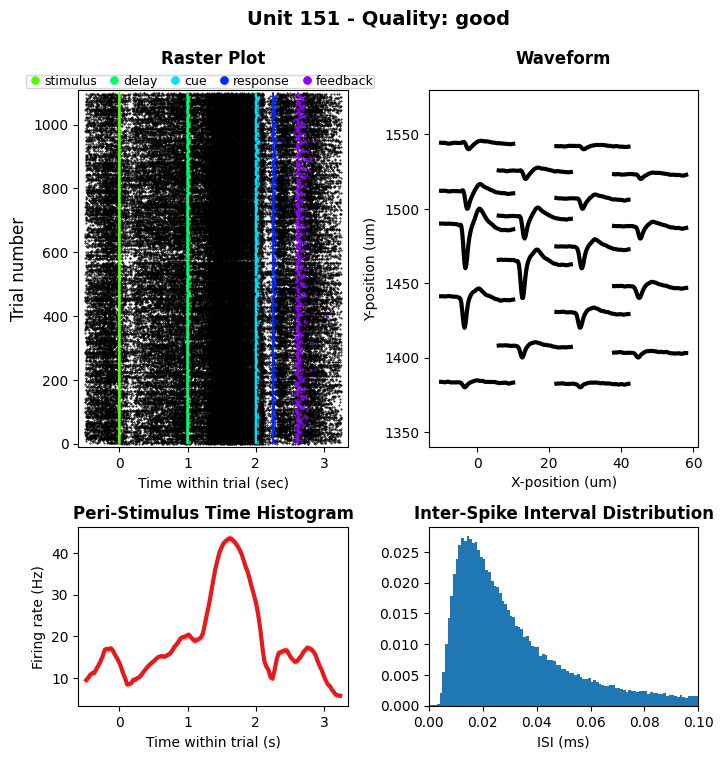

In [8]:
"""Generate unit summary plot."""

UNIT = 151

# Load spike times and amplitudes
unit_index = np.where(units.id[:] == UNIT)[0][0]
spike_times = units.spike_times_index[unit_index]
mean_waveform = units.mean_waveform_index[unit_index]
mean_waveform_electrodes = np.copy(
    units.mean_waveform_electrodes_index[unit_index]
)
electrodes_group = units.electrodes_group[unit_index]
quality = units.quality[unit_index]
obs_trials = units.obs_trials_index[unit_index]
obs_trials = [x for x, c in zip(obs_trials, trial_completed) if c]

# Create figure and axes
fig = plt.figure(figsize=(8, 8))
gridspec = fig.add_gridspec(
    2, 2, height_ratios=(2, 1), hspace=0.3, wspace=0.3
)
ax_raster = fig.add_subplot(gridspec[0, 0])
ax_psth = fig.add_subplot(gridspec[1, 0])
ax_waveform = fig.add_subplot(gridspec[0, 1])
ax_inter_spike_interval = fig.add_subplot(gridspec[1, 1])

# Plot raster
spike_times_per_obs_trial = plot_raster.plot_raster(
    ax_raster, spike_times, trial_phase_times, obs_trials
)

# Plot firing rate
plot_waveform_mean.plot_waveform_mean(
    ax_waveform,
    mean_waveform,
    mean_waveform_electrodes,
    electrodes_df,
    electrodes_group,
)

# Plot PSTH
plot_psth.plot_psth(ax_psth, spike_times_per_obs_trial)

# Plot ISI distribution
plot_isi_distribution.plot_isi_distribution(
    ax_inter_spike_interval, spike_times
)

# Create title for plot
plt.suptitle(
    f"Unit {unit_index} - Quality: {quality}",
    weight="bold",
    fontsize=14,
)
